In [9]:
import numpy as np
import pandas as pd

In [10]:
X_train= pd.read_csv("data/preprocessed/X_train.csv")
X_test = pd.read_csv("data/preprocessed/X_test.csv")
y_train = pd.read_csv("data/preprocessed/y_train.csv")
y_test = pd.read_csv("data/preprocessed/y_test.csv")

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, r2_score, precision_score, f1_score

In [12]:
X_train.shape

(79960, 9)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, f1_score

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, f1_score, roc_auc_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler,
    BorderlineSMOTE,
    SVMSMOTE,
    SMOTENC,
    ADASYN
)

from imblearn.under_sampling import RandomUnderSampler

def get_sampler(strategy):
    if strategy is None:
        return None
    samplers = {
        "smote": SMOTE(random_state=42),
        "ros": RandomOverSampler(random_state=42),
        "rus": RandomUnderSampler(random_state=42),
        "bsmote": BorderlineSMOTE(random_state=42),
        "svm_smote": SVMSMOTE(random_state=42),
        "sm_smote": SMOTENC(categorical_features='auto', random_state=42),  # Replace 'auto' if you know categorical indices
        "sdasyn": ADASYN(random_state=42)
    }
    return samplers.get(strategy.lower())

def test_models(models_list, X, y, n_splits=5, oversampling=None):
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    sampler = get_sampler(oversampling)

    for model in models_list:
        try:
            model_name = model.__class__.__name__
            print(f"\nEvaluating {model_name}:")

            recalls, precisions, accuracies, f1s, aucs, cm_list = [], [], [], [], [], []

            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # Apply oversampling if selected
                if sampler is not None:
                    try:
                        X_train, y_train = sampler.fit_resample(X_train, y_train)
                    except Exception as e:
                        print(f"Oversampling failed for {model_name}: {e}")
                        continue

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                try:
                    y_prob = model.predict_proba(X_test)[:, 1]
                    auc = roc_auc_score(y_test, y_prob)
                except:
                    auc = np.nan

                recalls.append(recall_score(y_test, y_pred, average='binary', zero_division=0))
                precisions.append(precision_score(y_test, y_pred, average='binary', zero_division=0))
                accuracies.append(accuracy_score(y_test, y_pred))
                f1s.append(f1_score(y_test, y_pred, average='binary', zero_division=0))
                aucs.append(auc)

                cm = confusion_matrix(y_test, y_pred)
                cm_list.append(cm)

            # Mean metrics
            recall_mean = np.mean(recalls)
            precision_mean = np.mean(precisions)
            accuracy_mean = np.mean(accuracies)
            f1_mean = np.mean(f1s)
            auc_mean = np.nanmean(aucs)

            avg_cm = np.mean(cm_list, axis=0).astype(int)

            plt.figure(figsize=(6, 4))
            sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=np.unique(y), yticklabels=np.unique(y))
            plt.title(f"Confusion Matrix - {model_name}")
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            print(f"Recall: {recall_mean:.4f}, Precision: {precision_mean:.4f}, "
                  f"Accuracy: {accuracy_mean:.4f}, F1: {f1_mean:.4f}, AUC: {auc_mean:.4f}")

            results.append({
                "Model": model_name,
                "Recall": recall_mean,
                "Precision": precision_mean,
                "Accuracy": accuracy_mean,
                "F1 Score": f1_mean,
                "AUC": auc_mean
            })
        except Exception as e:
            print(f"Exception occured while evaluating {model}: {e}")

    return pd.DataFrame(results)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Class balancing ratio for XGBoost, LightGBM, and CatBoost
scale_pos_weight = y_train["opened"].value_counts()[0] / y_train["opened"].value_counts()[1]

models_list = [

    # Logistic Regression with class_weight
    LogisticRegression(class_weight='balanced', max_iter=1000),

    # Random Forest with class_weight
    RandomForestClassifier(class_weight='balanced', n_estimators=100),

    # Naive Bayes (don't support class_weight directly)
    GaussianNB(),
    BernoulliNB(),
    MultinomialNB(),

    # KNN (no native class balancing, but works with SMOTE)
    KNeighborsClassifier(),

    # XGBoost with scale_pos_weight
    XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss'),

    # LightGBM with class balancing
    LGBMClassifier(class_weight='balanced'),

    # CatBoost with scale_pos_weight
    CatBoostClassifier(scale_pos_weight=scale_pos_weight, verbose=0),

    # # SVM with class_weight
    # SVC(class_weight='balanced', probability=True),  # probability=True needed for AUC
]



Evaluating LogisticRegression:


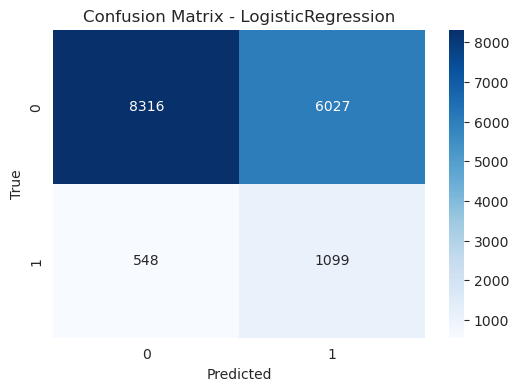

Recall: 0.6673, Precision: 0.1543, Accuracy: 0.5888, F1: 0.2506, AUC: 0.6728

Evaluating RandomForestClassifier:


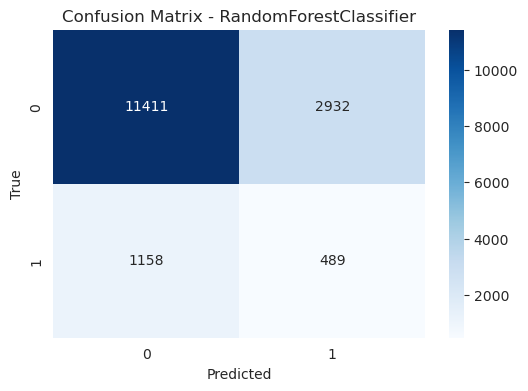

Recall: 0.2969, Precision: 0.1429, Accuracy: 0.7442, F1: 0.1929, AUC: 0.5831

Evaluating GaussianNB:


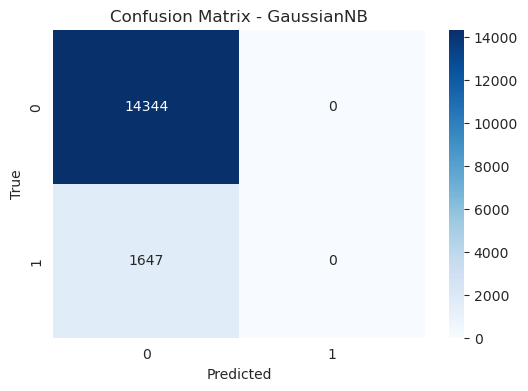

Recall: 0.0000, Precision: 0.0000, Accuracy: 0.8970, F1: 0.0000, AUC: 0.6648

Evaluating BernoulliNB:


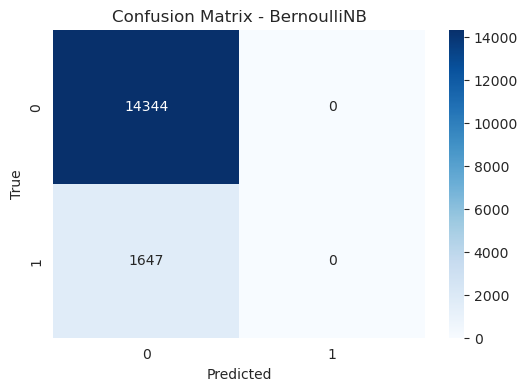

Recall: 0.0000, Precision: 0.0000, Accuracy: 0.8970, F1: 0.0000, AUC: 0.6454

Evaluating MultinomialNB:
Exception occured while evaluating MultinomialNB(): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


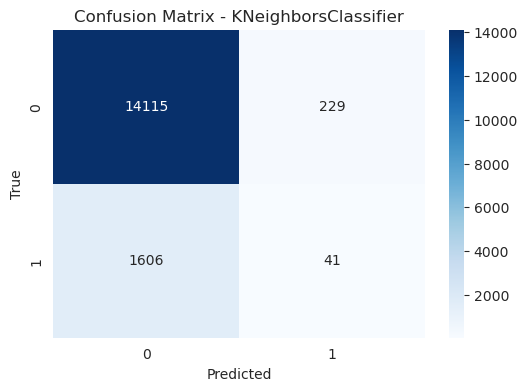

Recall: 0.0252, Precision: 0.1535, Accuracy: 0.8852, F1: 0.0433, AUC: 0.5663

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

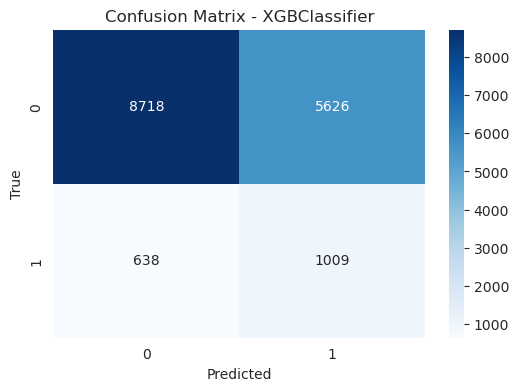

Recall: 0.6127, Precision: 0.1521, Accuracy: 0.6083, F1: 0.2438, AUC: 0.6516

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 6592, number of negative: 57376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 63968, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6591, number of negative: 57377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [I

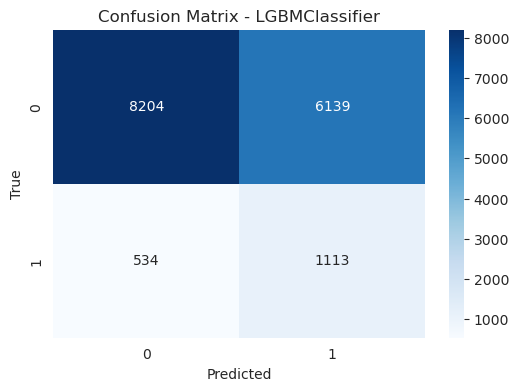

Recall: 0.6757, Precision: 0.1535, Accuracy: 0.5827, F1: 0.2502, AUC: 0.6727

Evaluating CatBoostClassifier:


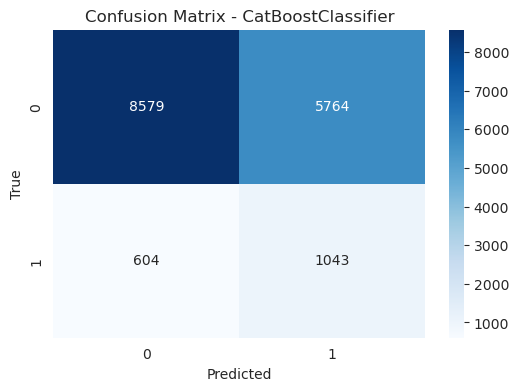

Recall: 0.6331, Precision: 0.1532, Accuracy: 0.6017, F1: 0.2467, AUC: 0.6601


In [25]:
res_no_oversampling = test_models(models_list, X_train, y_train["opened"], 5, oversampling = None)

In [26]:
# Without ros
res_no_oversampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.667313,0.154284,0.588807,0.250622,0.672754
1,RandomForestClassifier,0.296877,0.142932,0.744185,0.192948,0.583065
2,GaussianNB,0.000000,0.000000,0.896961,0.000000,0.664775
3,BernoulliNB,0.000000,0.000000,0.896961,0.000000,0.645374
4,KNeighborsClassifier,0.025246,0.153544,0.885243,0.043346,0.566294
5,XGBClassifier,0.612694,0.152145,0.608279,0.243758,0.651636
6,LGBMClassifier,0.675687,0.153509,0.582654,0.250174,0.672689
7,CatBoostClassifier,0.633085,0.153238,0.601726,0.246749,0.660102



Evaluating LogisticRegression:


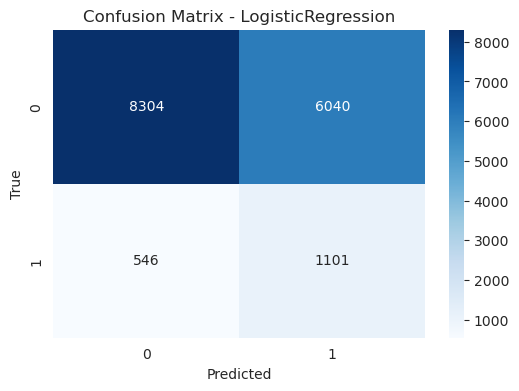

Recall: 0.6683, Precision: 0.1542, Accuracy: 0.5881, F1: 0.2506, AUC: 0.6727

Evaluating RandomForestClassifier:


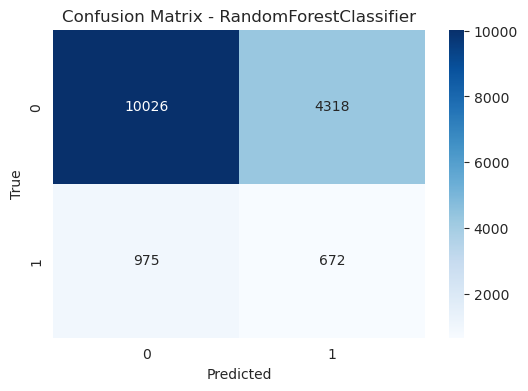

Recall: 0.4082, Precision: 0.1348, Accuracy: 0.6690, F1: 0.2026, AUC: 0.5821

Evaluating GaussianNB:


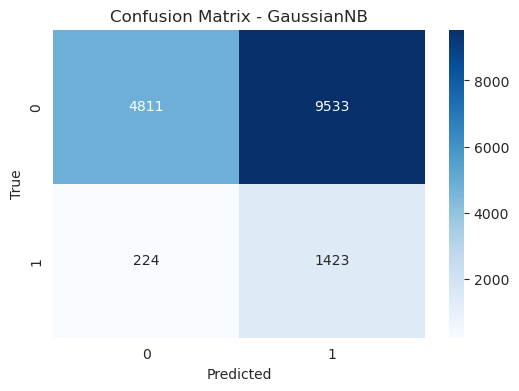

Recall: 0.8641, Precision: 0.1300, Accuracy: 0.3899, F1: 0.2259, AUC: 0.6649

Evaluating BernoulliNB:


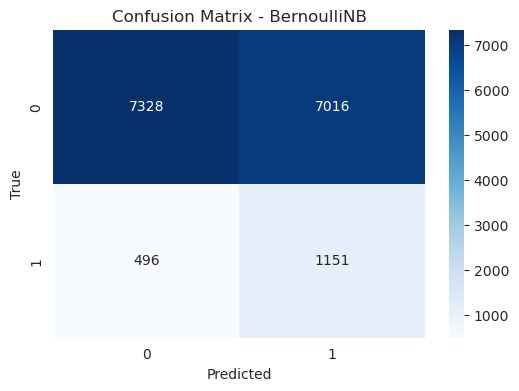

Recall: 0.6989, Precision: 0.1410, Accuracy: 0.5303, F1: 0.2346, AUC: 0.6451

Evaluating MultinomialNB:
Exception occured while evaluating MultinomialNB(): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


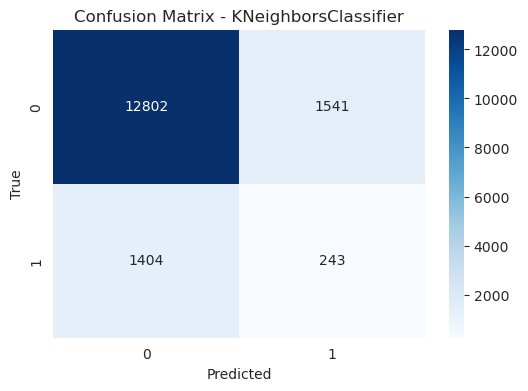

Recall: 0.1477, Precision: 0.1364, Accuracy: 0.8158, F1: 0.1418, AUC: 0.5627

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:22:07] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:22:07] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:22:07] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:22:07] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

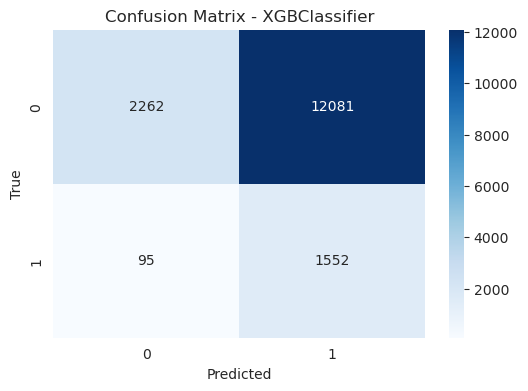

Recall: 0.9419, Precision: 0.1138, Accuracy: 0.2385, F1: 0.2031, AUC: 0.6472

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 57376, number of negative: 57376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 114752, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 57377, number of negative: 57377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 114754,

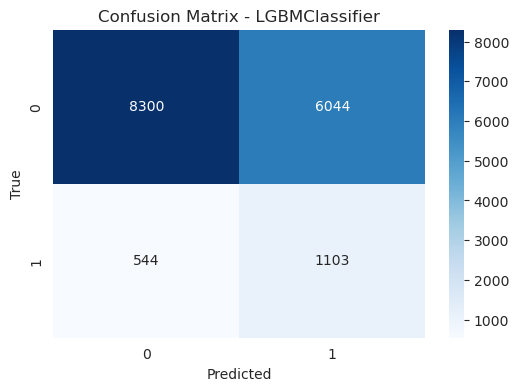

Recall: 0.6694, Precision: 0.1543, Accuracy: 0.5880, F1: 0.2508, AUC: 0.6725

Evaluating CatBoostClassifier:


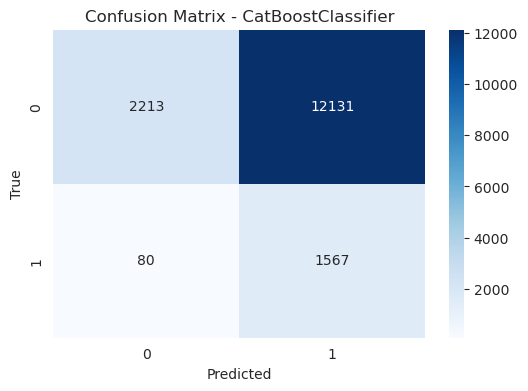

Recall: 0.9515, Precision: 0.1145, Accuracy: 0.2364, F1: 0.2043, AUC: 0.6575


In [27]:
res_random_oversampling = test_models(models_list, X_train, y_train["opened"], 5, oversampling = "ros")

In [28]:
res_random_oversampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.668284,0.154210,0.588119,0.250591,0.672714
1,RandomForestClassifier,0.408177,0.134752,0.669010,0.202604,0.582081
2,GaussianNB,0.864061,0.129955,0.389882,0.225927,0.664854
3,BernoulliNB,0.698871,0.140990,0.530253,0.234635,0.645054
4,KNeighborsClassifier,0.147712,0.136407,0.815770,0.141813,0.562658
5,XGBClassifier,0.941862,0.113842,0.238544,0.203131,0.647181
6,LGBMClassifier,0.669377,0.154330,0.587994,0.250828,0.672522
7,CatBoostClassifier,0.951450,0.114453,0.236431,0.204325,0.657492



Evaluating LogisticRegression:


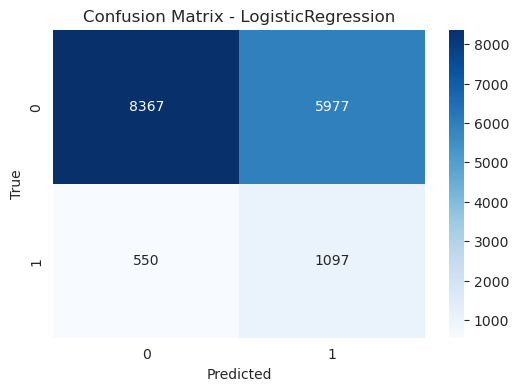

Recall: 0.6662, Precision: 0.1552, Accuracy: 0.5919, F1: 0.2518, AUC: 0.6728

Evaluating RandomForestClassifier:


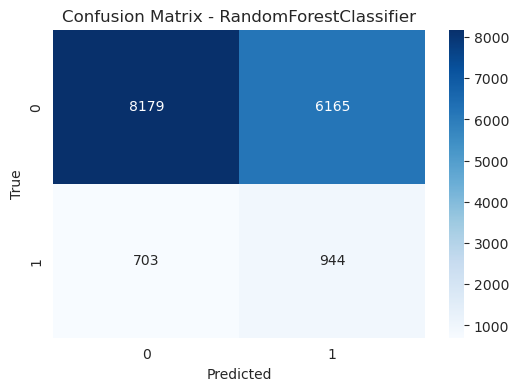

Recall: 0.5729, Precision: 0.1328, Accuracy: 0.5705, F1: 0.2156, AUC: 0.5985

Evaluating GaussianNB:


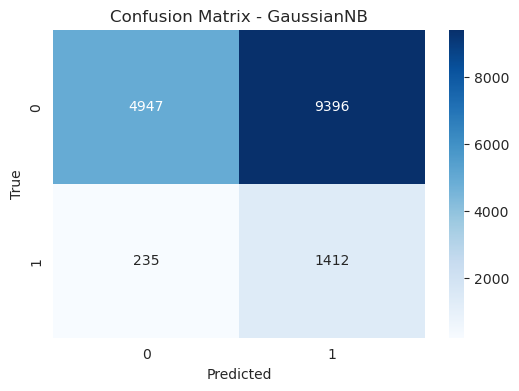

Recall: 0.8570, Precision: 0.1307, Accuracy: 0.3977, F1: 0.2268, AUC: 0.6643

Evaluating BernoulliNB:


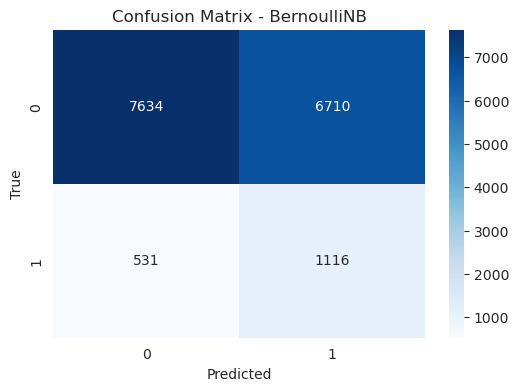

Recall: 0.6776, Precision: 0.1428, Accuracy: 0.5472, F1: 0.2358, AUC: 0.6447

Evaluating MultinomialNB:
Exception occured while evaluating MultinomialNB(): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


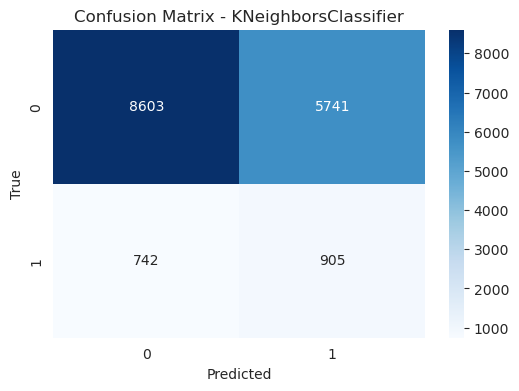

Recall: 0.5496, Precision: 0.1363, Accuracy: 0.5946, F1: 0.2184, AUC: 0.6023

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:04] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:04] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:04] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:04] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

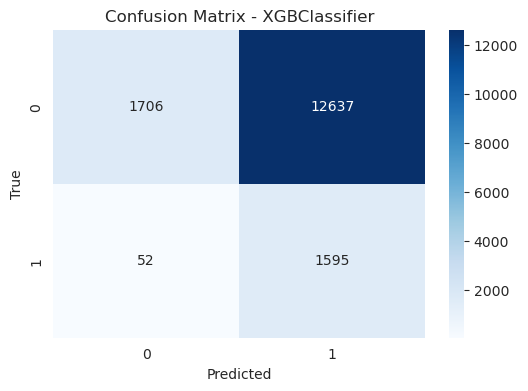

Recall: 0.9681, Precision: 0.1121, Accuracy: 0.2065, F1: 0.2009, AUC: 0.6446

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 6592, number of negative: 6592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 13184, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 6591, number of negative: 6591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 13182, numbe

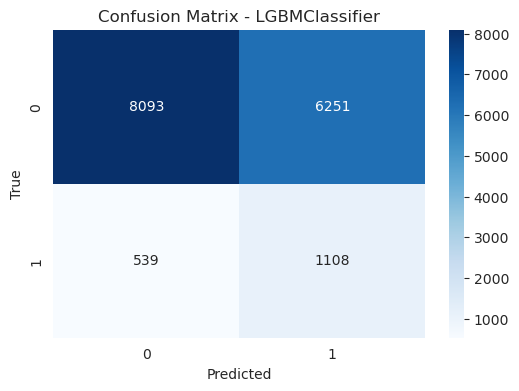

Recall: 0.6724, Precision: 0.1506, Accuracy: 0.5754, F1: 0.2461, AUC: 0.6659

Evaluating CatBoostClassifier:


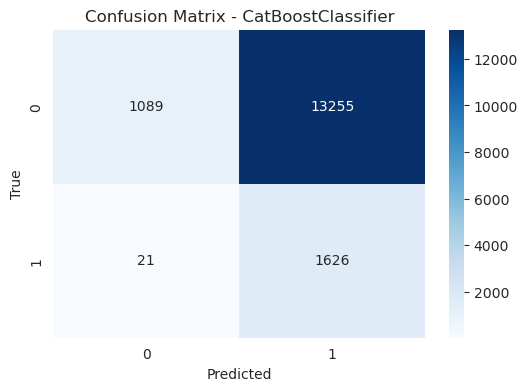

Recall: 0.9868, Precision: 0.1093, Accuracy: 0.1698, F1: 0.1968, AUC: 0.6689


In [29]:
res_random_undersampling = test_models(models_list, X_train, y_train["opened"], 5, oversampling = "rus")

In [30]:
res_random_undersampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.666221,0.155203,0.591858,0.251752,0.672755
1,RandomForestClassifier,0.572883,0.132780,0.570485,0.215589,0.598454
2,GaussianNB,0.857021,0.130679,0.397699,0.226773,0.664257
3,BernoulliNB,0.677624,0.142770,0.547199,0.235760,0.644723
4,KNeighborsClassifier,0.549581,0.136253,0.594585,0.218366,0.602277
5,XGBClassifier,0.968079,0.112078,0.206453,0.200897,0.644602
6,LGBMClassifier,0.672412,0.150645,0.575350,0.246115,0.665869
7,CatBoostClassifier,0.986770,0.109269,0.169785,0.196750,0.668915


In [33]:
res_no_oversampling['source'] = 'no_oversampling'
res_random_oversampling['source'] = 'random_oversampling'
res_random_undersampling['source'] = 'random_undersampling'

res_all = pd.concat(
    [res_no_oversampling, res_random_oversampling, res_random_undersampling],
    ignore_index=True
)

In [34]:
res_all

,Model,Recall,Precision,Accuracy,F1 Score,AUC,source
0,LogisticRegression,0.667313,0.154284,0.588807,0.250622,0.672754,no_oversampling
1,RandomForestClassifier,0.296877,0.142932,0.744185,0.192948,0.583065,no_oversampling
2,GaussianNB,0.000000,0.000000,0.896961,0.000000,0.664775,no_oversampling
3,BernoulliNB,0.000000,0.000000,0.896961,0.000000,0.645374,no_oversampling
4,KNeighborsClassifier,0.025246,0.153544,0.885243,0.043346,0.566294,no_oversampling
5,XGBClassifier,0.612694,0.152145,0.608279,0.243758,0.651636,no_oversampling
6,LGBMClassifier,0.675687,0.153509,0.582654,0.250174,0.672689,no_oversampling
7,CatBoostClassifier,0.633085,0.153238,0.601726,0.246749,0.660102,no_oversampling
8,LogisticRegression,0.668284,0.154210,0.588119,0.250591,0.672714,random_oversampling
9,RandomForestClassifier,0.408177,0.134752,0.669010,0.202604,0.582081,random_oversampling


In [35]:
# Out of all algorithms, Xgb, catboost, and logistic regression performs good without any oversampling!

In [36]:
# scale_pos_weight = y_train["opened"].value_counts()[0] / y_train["opened"].value_counts()[1]

In [37]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(silent=True, scale_pos_weight = scale_pos_weight)

# Define the parameter grid for CatBoost
param_grid = {
    'iterations': [100],
    'learning_rate': [0.005, 0.01, 0.05],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [16, 32, 64],
    'bagging_temperature': [0.05, 0.1, 0.5],
}

# Set up GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring="recall")

# Fit the grid search
grid_search_catboost.fit(X_train, y_train["opened"])

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search_catboost.best_params_}")

# Best model
best_catboost_model = grid_search_catboost.best_estimator_

# Evaluate the best model
y_pred = best_catboost_model.predict(X_test)
print(f"Recall: {recall_score(y_test["opened"], y_pred)}")
print(f"Precision: {precision_score(y_test["opened"], y_pred)}")
print(f"Accuracy: {accuracy_score(y_test["opened"], y_pred)}")
print(f"F1 Score: {f1_score(y_test["opened"], y_pred)}")
print(f"AUC: {roc_auc_score(y_test["opened"], best_catboost_model.predict_proba(X_test)[:, 1])}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters: {'bagging_temperature': 0.05, 'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
Recall: 0.707977207977208
Precision: 0.15612565445026177
Accuracy: 0.5660830415207604
F1 Score: 0.25583390528483185
AUC: 0.6693780303710968


In [44]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

# Define the LGBMClassifier
lgbm_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,  # Adjust class weights for imbalanced data
    verbosity=0  # Suppress verbose output
)

# Define the parameter grid for LightGBM
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [4, 6],
    'reg_lambda': [1, 3, 5],           # Equivalent to l2_leaf_reg in XGBoost
    'subsample': [0.8, 1],             # Bagging analog
    'colsample_bytree': [0.8, 1],      # Feature sampling
    'min_child_weight': [1, 3],        # Controls leaf size, similar to min_child_weight in XGBoost
}

# Set up GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="recall"
)

# Fit the grid search
grid_search_lgbm.fit(X_train, y_train["opened"])

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search_lgbm.best_params_}")

# Best model
best_lgbm_model = grid_search_lgbm.best_estimator_

# Evaluate the best model
y_pred = best_lgbm_model.predict(X_test)
print(f"Recall: {recall_score(y_test['opened'], y_pred)}")
print(f"Precision: {precision_score(y_test['opened'], y_pred)}")
print(f"Accuracy: {accuracy_score(y_test['opened'], y_pred)}")
print(f"F1 Score: {f1_score(y_test['opened'], y_pred)}")
print(f"AUC: {roc_auc_score(y_test['opened'], best_lgbm_model.predict_proba(X_test)[:, 1])}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7e7ea461c860>
Traceback (most recent call last):
  File "/home/kraten/miniconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7b7eccf54860>
Traceback (most recent call last):
  File "/home/kraten/miniconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_callback at 0x731787084860>
Traceback (most recent call last):
  File "/home/kraten/miniconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_cal

KeyboardInterrupt: 

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

# Define the Logistic Regression model
logreg_model = LogisticRegression(
    solver='liblinear',  # good for small datasets & supports L1 regularization
    class_weight='balanced'  # useful for imbalanced datasets
)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # Regularization strength (smaller -> stronger regularization)
    'penalty': ['l1', 'l2']         # Type of regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="recall"
)

# Fit the grid search
grid_search.fit(X_train, y_train["opened"])

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Best model
best_logreg_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_logreg_model.predict(X_test)
print(f"Recall: {recall_score(y_test['opened'], y_pred)}")
print(f"Precision: {precision_score(y_test['opened'], y_pred)}")
print(f"Accuracy: {accuracy_score(y_test['opened'], y_pred)}")
print(f"F1 Score: {f1_score(y_test['opened'], y_pred)}")
print(f"AUC: {roc_auc_score(y_test['opened'], best_logreg_model.predict_proba(X_test)[:, 1])}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'C': 1, 'penalty': 'l1'}
Recall: 0.6775878442545109
Precision: 0.15823907740075405
Accuracy: 0.5862931465732867
F1 Score: 0.2565623876303488
AUC: 0.6713094256475678


In [85]:
from sklearn.base import BaseEstimator, clone
import numpy as np  # Don't forget to import numpy

class EmailClickPredictor(BaseEstimator):
    def __init__(self, model1=None, model2=None):
        self.model1 = model1
        self.model2 = model2

    def fit(self, X, y):
        X_ = X.copy()
        X_["opened_proba"] = self.model1.predict_proba(X_)[:, 1]
        self.model2.fit(X_, y)
        return self

    def predict(self, X):
        X_ = X.copy()
        X_["opened_proba"] = self.model1.predict_proba(X_)[:, 1]
        return self.model2.predict(X_)

    def predict_proba(self, X):
        X_ = X.copy()
        opened_proba = self.model1.predict_proba(X_)[:, 1]
        X_["opened_proba"] = opened_proba
        clicked_proba = self.model2.predict_proba(X_)[:, 1]
        return np.vstack([1 - clicked_proba, clicked_proba]).T

    def get_params(self, deep=True):
        return {
            "model1": self.model1,
            "model2": self.model2,
        } | (
            {
                f"model2__{key}": value
                for key, value in self.model2.get_params(deep=True).items()
            } if deep and self.model2 is not None else {}
        )

    def set_params(self, **params):
        model2_params = {}
        for key, value in params.items():
            if key.startswith("model2__"):
                model2_params[key.split("__", 1)[1]] = value
            else:
                setattr(self, key, value)
        if model2_params and self.model2 is not None:
            self.model2.set_params(**model2_params)
        return self


In [86]:
model = EmailClickPredictor(best_catboost_model, LogisticRegression())
model.fit(X_train, y_train["clicked"])
y_pred_clicked = model.predict(X_test)

In [87]:
recall_score(y_test["clicked"], y_pred_clicked)

0.0

In [70]:
def test_models2(model1, models_list, X, y, n_splits=5, oversampling=None):
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    sampler = get_sampler(oversampling)

    for base_model in models_list:
        try:
            model_name = base_model.__class__.__name__
            print(f"\nEvaluating {model_name}:")
            model = EmailClickPredictor(model1, base_model)
            recalls, precisions, accuracies, f1s, aucs, cm_list = [], [], [], [], [], []

            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # Apply oversampling if selected
                if sampler is not None:
                    try:
                        X_train, y_train = sampler.fit_resample(X_train, y_train)
                    except Exception as e:
                        print(f"Oversampling failed for {model_name}: {e}")
                        continue

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                try:
                    y_prob = model.predict_proba(X_test)[:, 1]
                    auc = roc_auc_score(y_test, y_prob)
                except:
                    auc = np.nan

                recalls.append(recall_score(y_test, y_pred, average='binary', zero_division=0))
                precisions.append(precision_score(y_test, y_pred, average='binary', zero_division=0))
                accuracies.append(accuracy_score(y_test, y_pred))
                f1s.append(f1_score(y_test, y_pred, average='binary', zero_division=0))
                aucs.append(auc)

                cm = confusion_matrix(y_test, y_pred)
                cm_list.append(cm)

            # Mean metrics
            recall_mean = np.mean(recalls)
            precision_mean = np.mean(precisions)
            accuracy_mean = np.mean(accuracies)
            f1_mean = np.mean(f1s)
            auc_mean = np.nanmean(aucs)

            avg_cm = np.mean(cm_list, axis=0).astype(int)

            plt.figure(figsize=(6, 4))
            sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=np.unique(y), yticklabels=np.unique(y))
            plt.title(f"Confusion Matrix - {model_name}")
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            print(f"Recall: {recall_mean:.4f}, Precision: {precision_mean:.4f}, "
                  f"Accuracy: {accuracy_mean:.4f}, F1: {f1_mean:.4f}, AUC: {auc_mean:.4f}")

            results.append({
                "Model": model_name,
                "Recall": recall_mean,
                "Precision": precision_mean,
                "Accuracy": accuracy_mean,
                "F1 Score": f1_mean,
                "AUC": auc_mean
            })
        except Exception as e:
            print(f"Exception occured while evaluating {model}: {e}")

    return pd.DataFrame(results)

In [72]:
scale_pos_weight = y_train["clicked"].value_counts()[0] / y_train["clicked"].value_counts()[1]

models_list = [

    # Logistic Regression with class_weight
    LogisticRegression(class_weight='balanced', max_iter=1000),

    # Random Forest with class_weight
    RandomForestClassifier(class_weight='balanced', n_estimators=100),

    # Naive Bayes (don't support class_weight directly)
    GaussianNB(),
    BernoulliNB(),
    MultinomialNB(),

    # KNN (no native class balancing, but works with SMOTE)
    KNeighborsClassifier(),

    # XGBoost with scale_pos_weight
    XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss'),

    # LightGBM with class balancing
    LGBMClassifier(class_weight='balanced'),

    # CatBoost with scale_pos_weight
    CatBoostClassifier(scale_pos_weight=scale_pos_weight, verbose=0),

]


Evaluating LogisticRegression:


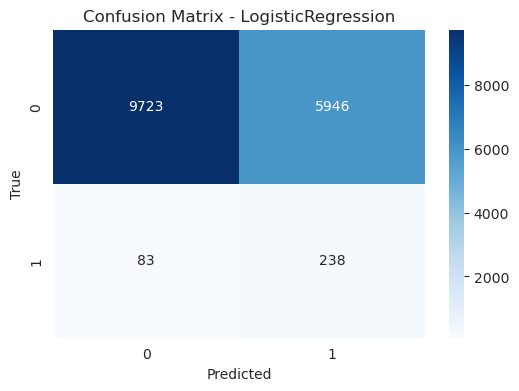

Recall: 0.7403, Precision: 0.0386, Accuracy: 0.6229, F1: 0.0734, AUC: 0.7511

Evaluating RandomForestClassifier:


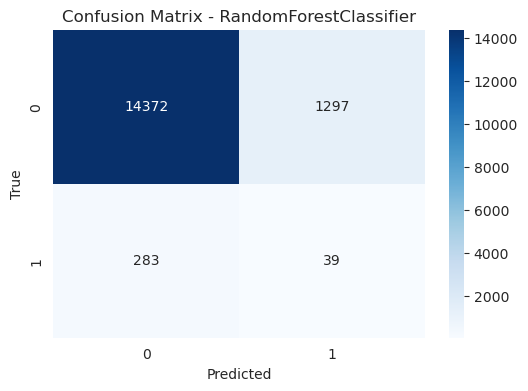

Recall: 0.1227, Precision: 0.0297, Accuracy: 0.9012, F1: 0.0478, AUC: 0.5729

Evaluating GaussianNB:


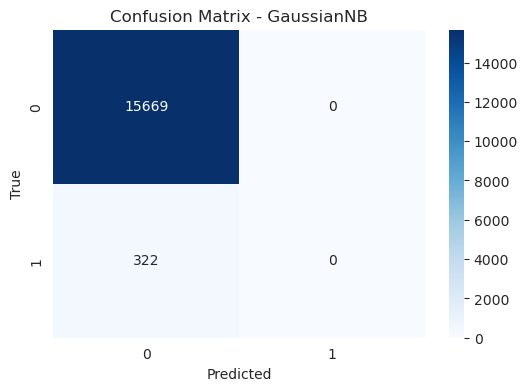

Recall: 0.0000, Precision: 0.0000, Accuracy: 0.9798, F1: 0.0000, AUC: 0.7302

Evaluating BernoulliNB:


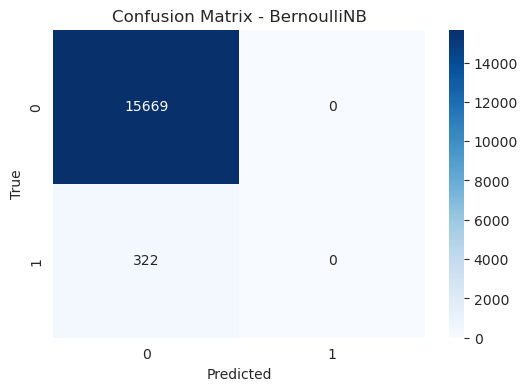

Recall: 0.0000, Precision: 0.0000, Accuracy: 0.9798, F1: 0.0000, AUC: 0.6968

Evaluating MultinomialNB:
Exception occured while evaluating EmailClickPredictor(model1=<catboost.core.CatBoostClassifier object at 0x7b291ef7fec0>,
                    model2=MultinomialNB()): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


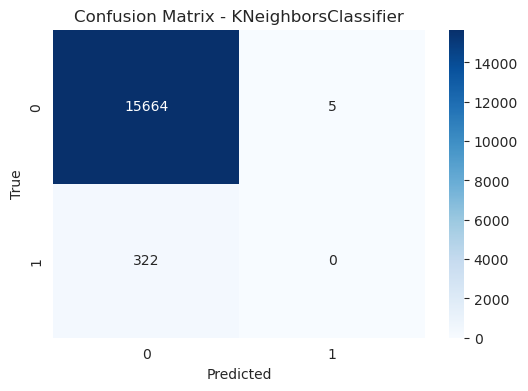

Recall: 0.0019, Precision: 0.1333, Accuracy: 0.9795, F1: 0.0036, AUC: 0.5414

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:22:18] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:22:18] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:22:18] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:22:18] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

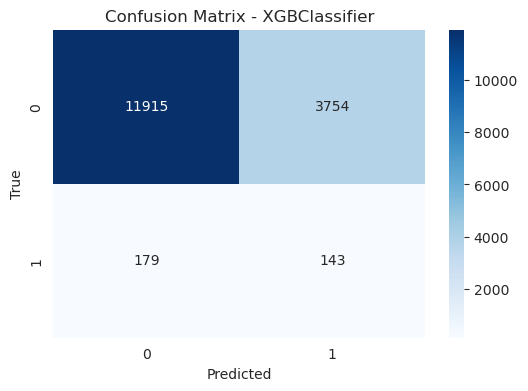

Recall: 0.4451, Precision: 0.0369, Accuracy: 0.7540, F1: 0.0681, AUC: 0.6853

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 1291, number of negative: 62677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 63968, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1291, number of negative: 62677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM]

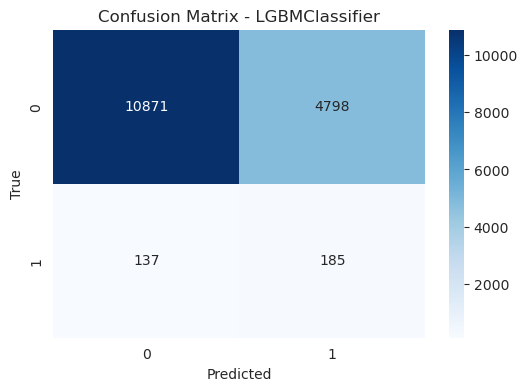

Recall: 0.5753, Precision: 0.0372, Accuracy: 0.6914, F1: 0.0699, AUC: 0.7104

Evaluating CatBoostClassifier:


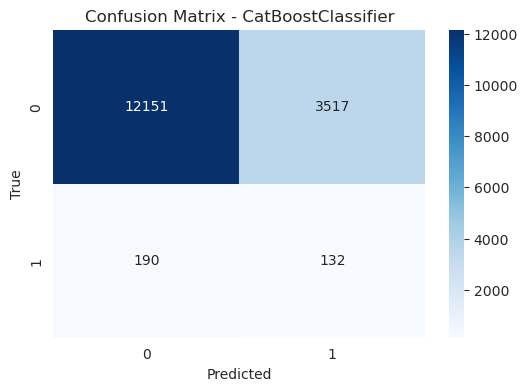

Recall: 0.4098, Precision: 0.0362, Accuracy: 0.7681, F1: 0.0665, AUC: 0.6793


In [73]:
res_no_oversampling = test_models2(best_catboost_model, models_list, X_train, y_train["clicked"], 5, oversampling = None)

In [74]:
res_no_oversampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.740263,0.038602,0.622949,0.073377,0.751103
1,RandomForestClassifier,0.122743,0.029657,0.901188,0.047765,0.572871
2,GaussianNB,0.000000,0.000000,0.979827,0.000000,0.730172
3,BernoulliNB,0.000000,0.000000,0.979827,0.000000,0.696835
4,KNeighborsClassifier,0.001860,0.133333,0.979540,0.003648,0.541436
5,XGBClassifier,0.445128,0.036880,0.754040,0.068113,0.685339
6,LGBMClassifier,0.575326,0.037234,0.691396,0.069941,0.710399
7,CatBoostClassifier,0.409780,0.036216,0.768134,0.066549,0.679281



Evaluating LogisticRegression:


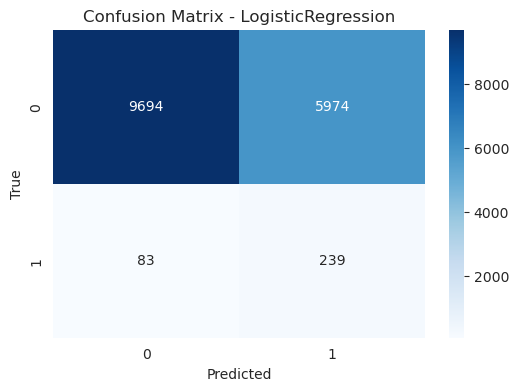

Recall: 0.7427, Precision: 0.0385, Accuracy: 0.6212, F1: 0.0733, AUC: 0.7511

Evaluating RandomForestClassifier:


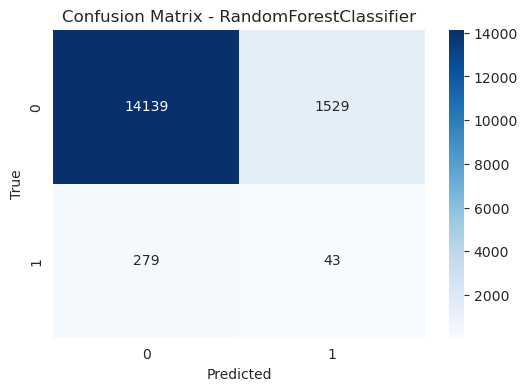

Recall: 0.1351, Precision: 0.0277, Accuracy: 0.8869, F1: 0.0460, AUC: 0.5790

Evaluating GaussianNB:


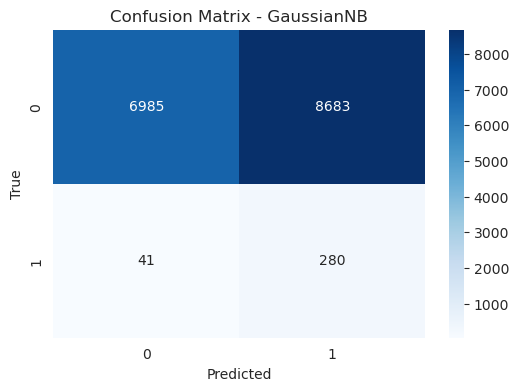

Recall: 0.8704, Precision: 0.0313, Accuracy: 0.4544, F1: 0.0605, AUC: 0.7301

Evaluating BernoulliNB:


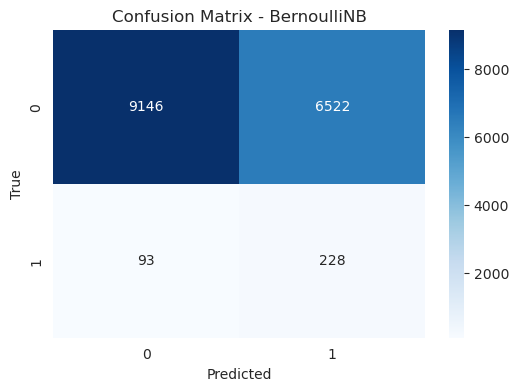

Recall: 0.7092, Precision: 0.0339, Accuracy: 0.5863, F1: 0.0647, AUC: 0.6960

Evaluating MultinomialNB:
Exception occured while evaluating EmailClickPredictor(model1=<catboost.core.CatBoostClassifier object at 0x7b291ef7fec0>,
                    model2=MultinomialNB()): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


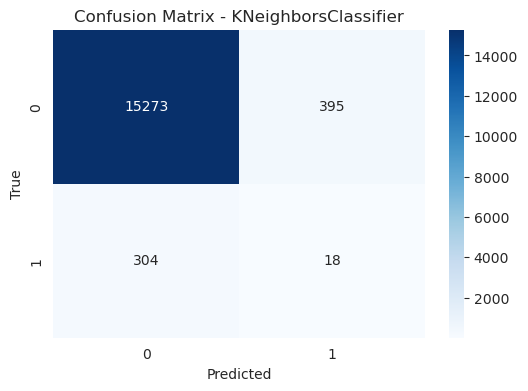

Recall: 0.0558, Precision: 0.0435, Accuracy: 0.9562, F1: 0.0489, AUC: 0.5447

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

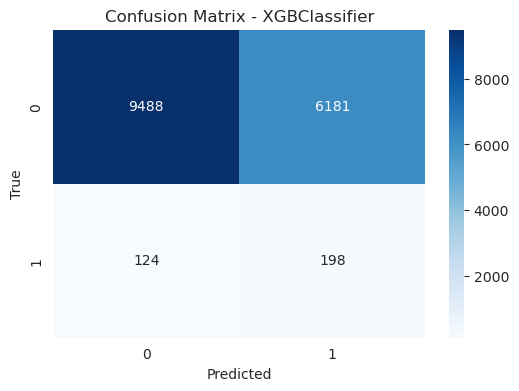

Recall: 0.6156, Precision: 0.0311, Accuracy: 0.6057, F1: 0.0593, AUC: 0.6556

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 62677, number of negative: 62677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 125354, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 62677, number of negative: 62677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1253

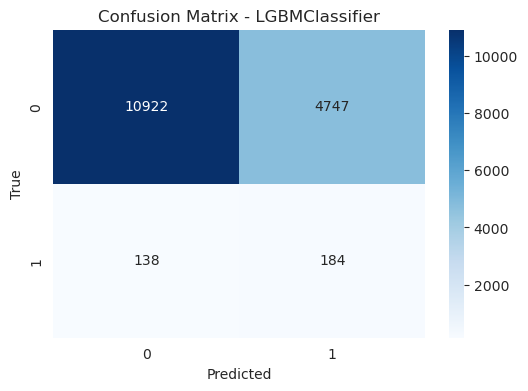

Recall: 0.5722, Precision: 0.0374, Accuracy: 0.6945, F1: 0.0703, AUC: 0.7110

Evaluating CatBoostClassifier:


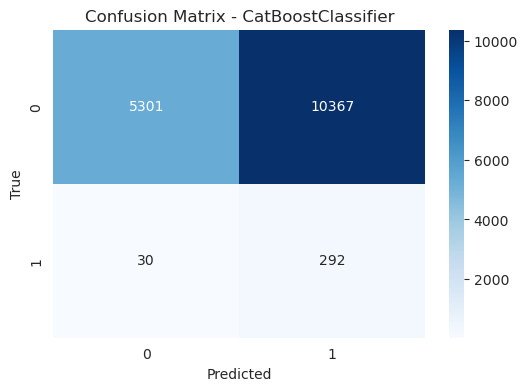

Recall: 0.9064, Precision: 0.0275, Accuracy: 0.3498, F1: 0.0533, AUC: 0.7128


In [75]:
res_random_oversampling = test_models2(best_catboost_model, models_list, X_train, y_train["clicked"], 5, oversampling = "ros")

In [76]:
res_random_oversampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.742740,0.038548,0.621198,0.073292,0.751143
1,RandomForestClassifier,0.135140,0.027726,0.886906,0.046010,0.578992
2,GaussianNB,0.870440,0.031328,0.454377,0.060478,0.730050
3,BernoulliNB,0.709234,0.033900,0.586268,0.064706,0.696024
4,KNeighborsClassifier,0.055795,0.043517,0.956216,0.048880,0.544663
5,XGBClassifier,0.615611,0.031128,0.605728,0.059256,0.655582
6,LGBMClassifier,0.572229,0.037440,0.694535,0.070279,0.711002
7,CatBoostClassifier,0.906388,0.027460,0.349800,0.053300,0.712787



Evaluating LogisticRegression:


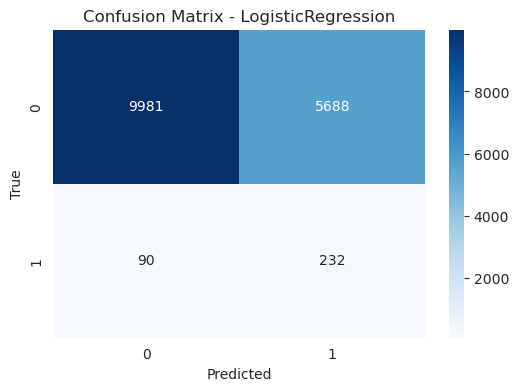

Recall: 0.7204, Precision: 0.0393, Accuracy: 0.6387, F1: 0.0745, AUC: 0.7465

Evaluating RandomForestClassifier:


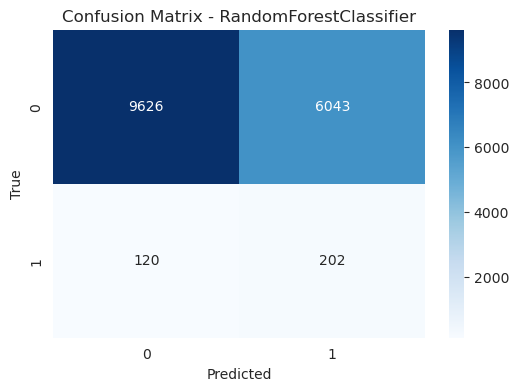

Recall: 0.6280, Precision: 0.0324, Accuracy: 0.6146, F1: 0.0617, AUC: 0.6804

Evaluating GaussianNB:


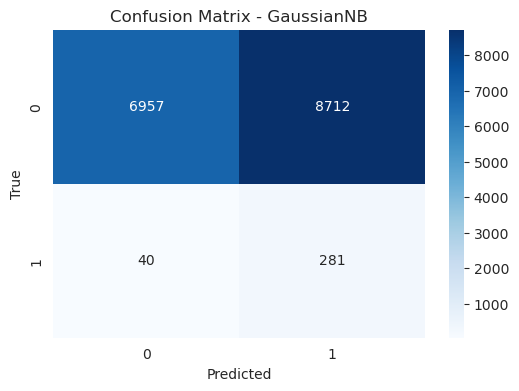

Recall: 0.8735, Precision: 0.0313, Accuracy: 0.4527, F1: 0.0605, AUC: 0.7293

Evaluating BernoulliNB:


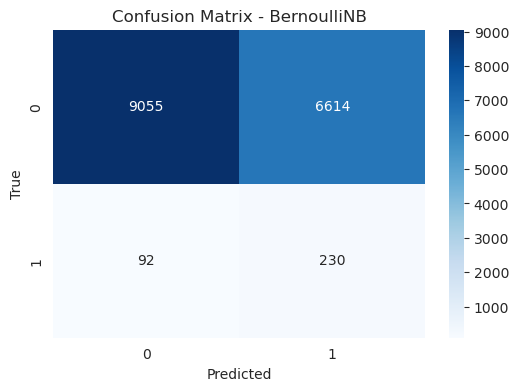

Recall: 0.7136, Precision: 0.0337, Accuracy: 0.5806, F1: 0.0643, AUC: 0.6947

Evaluating MultinomialNB:
Exception occured while evaluating EmailClickPredictor(model1=<catboost.core.CatBoostClassifier object at 0x7b291ef7fec0>,
                    model2=MultinomialNB()): Negative values in data passed to MultinomialNB (input X).

Evaluating KNeighborsClassifier:


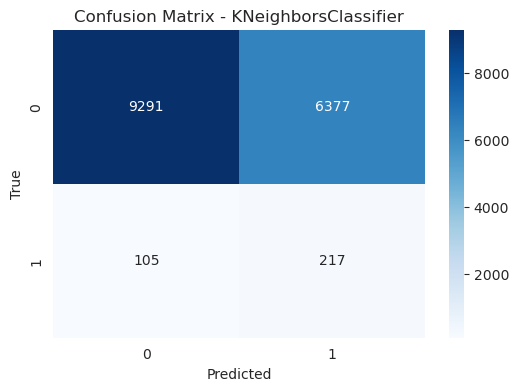

Recall: 0.6733, Precision: 0.0329, Accuracy: 0.5946, F1: 0.0628, AUC: 0.6745

Evaluating XGBClassifier:


/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:55] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:55] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:55] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kraten/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:26:55] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

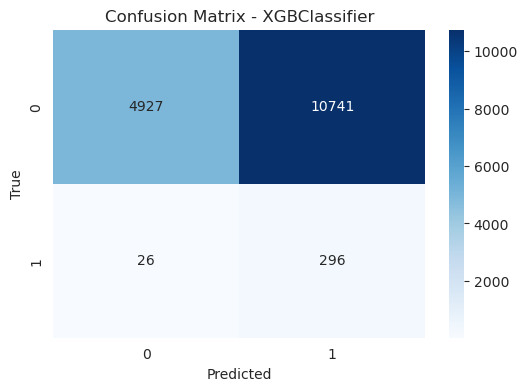

Recall: 0.9176, Precision: 0.0268, Accuracy: 0.3266, F1: 0.0521, AUC: 0.6849

Evaluating LGBMClassifier:
[LightGBM] [Info] Number of positive: 1291, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 2582, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1291, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 2582, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number 

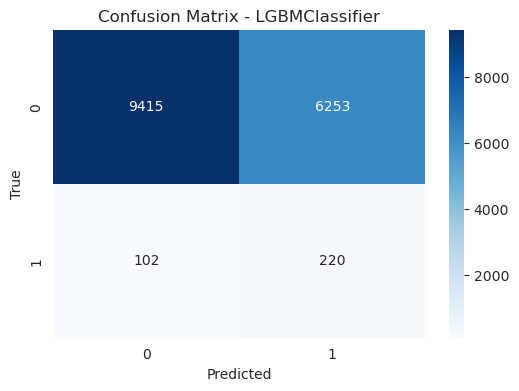

Recall: 0.6838, Precision: 0.0341, Accuracy: 0.6026, F1: 0.0649, AUC: 0.7053

Evaluating CatBoostClassifier:


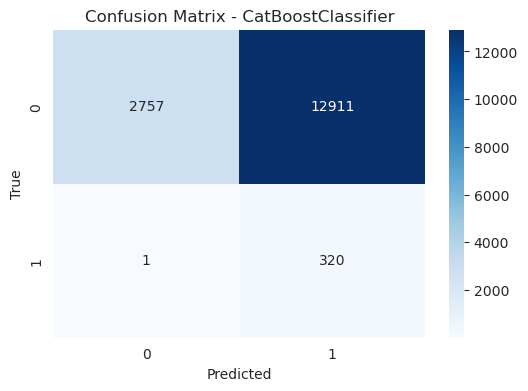

Recall: 0.9944, Precision: 0.0242, Accuracy: 0.1925, F1: 0.0473, AUC: 0.7427


In [77]:
res_random_undersampling = test_models2(best_catboost_model, models_list, X_train, y_train["clicked"], 5, oversampling = "rus")

In [78]:
res_random_undersampling

,Model,Recall,Precision,Accuracy,F1 Score,AUC
0,LogisticRegression,0.720416,0.039257,0.638669,0.074456,0.746488
1,RandomForestClassifier,0.628020,0.032448,0.614620,0.061708,0.680386
2,GaussianNB,0.873532,0.031335,0.452664,0.060499,0.729330
3,BernoulliNB,0.713580,0.033666,0.580640,0.064293,0.694716
4,KNeighborsClassifier,0.673300,0.032926,0.594597,0.062781,0.674546
5,XGBClassifier,0.917557,0.026819,0.326638,0.052114,0.684872
6,LGBMClassifier,0.683826,0.034083,0.602576,0.064927,0.705277
7,CatBoostClassifier,0.994418,0.024244,0.192496,0.047334,0.742705


In [79]:
res_no_oversampling['source'] = 'no_oversampling'
res_random_oversampling['source'] = 'random_oversampling'
res_random_undersampling['source'] = 'random_undersampling'

res_all = pd.concat(
    [res_no_oversampling, res_random_oversampling, res_random_undersampling],
    ignore_index=True
)

In [80]:
res_all

,Model,Recall,Precision,Accuracy,F1 Score,AUC,source
0,LogisticRegression,0.740263,0.038602,0.622949,0.073377,0.751103,no_oversampling
1,RandomForestClassifier,0.122743,0.029657,0.901188,0.047765,0.572871,no_oversampling
2,GaussianNB,0.000000,0.000000,0.979827,0.000000,0.730172,no_oversampling
3,BernoulliNB,0.000000,0.000000,0.979827,0.000000,0.696835,no_oversampling
4,KNeighborsClassifier,0.001860,0.133333,0.979540,0.003648,0.541436,no_oversampling
5,XGBClassifier,0.445128,0.036880,0.754040,0.068113,0.685339,no_oversampling
6,LGBMClassifier,0.575326,0.037234,0.691396,0.069941,0.710399,no_oversampling
7,CatBoostClassifier,0.409780,0.036216,0.768134,0.066549,0.679281,no_oversampling
8,LogisticRegression,0.742740,0.038548,0.621198,0.073292,0.751143,random_oversampling
9,RandomForestClassifier,0.135140,0.027726,0.886906,0.046010,0.578992,random_oversampling


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

# Define the Logistic Regression model
final_base_model = LogisticRegression(
    solver='liblinear',  # good for small datasets & supports L1 regularization
    class_weight='balanced'  # useful for imbalanced datasets
)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # Regularization strength (smaller -> stronger regularization)
    'penalty': ['l1', 'l2']         # Type of regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=final_base_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="recall"
)

# Fit the grid search
X_train_temp = X_train.copy()
X_train_temp["opened_proba"] = best_catboost_model.predict_proba(X_train)[:, 1]
grid_search.fit(X_train_temp, y_train["clicked"])

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Best model
best_final_base_model = grid_search.best_estimator_

best_final_model = EmailClickPredictor(best_catboost_model, best_final_base_model)
# Evaluate the best model
y_pred = best_final_model.predict(X_test)
print(f"Recall: {recall_score(y_test['clicked'], y_pred)}")
print(f"Precision: {precision_score(y_test['clicked'], y_pred)}")
print(f"Accuracy: {accuracy_score(y_test['clicked'], y_pred)}")
print(f"F1 Score: {f1_score(y_test['clicked'], y_pred)}")
print(f"AUC: {roc_auc_score(y_test['clicked'], best_final_model.predict_proba(X_test)[:, 1])}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: Convergenc

Best parameters: {'C': 10, 'penalty': 'l1'}
Recall: 0.7675438596491229
Precision: 0.04419749968430357
Accuracy: 0.6160580290145072
F1 Score: 0.08358208955223881
AUC: 0.759322476868941


/home/kraten/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [100]:
best_final_model

EmailClickPredictor(model1=<catboost.core.CatBoostClassifier object at 0x7b291ef7fec0>,
                    model2=LogisticRegression(C=10, class_weight='balanced',
                                              penalty='l1',
                                              solver='liblinear'))

In [101]:
import pickle

In [103]:
# with open("/home/kraten/Desktop/dev/sagar/artifacts/best_final.pkl", "wb") as f:
#     pickle.dump(best_final_model, f)

In [104]:
X_train.columns

Index(['hour_sin', 'weekday', 'user_past_purchases', 'hour_cos',
       'email_text_short_email', 'email_version_personalized',
       'user_country_FR', 'user_country_UK', 'user_country_US'],
      dtype='object')